In [1]:
import glob, json, argparse, os, sys
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.PDB import *

sys.path.insert(0,'/data1/groups/keatinglab/swans/savinovCollaboration/inhibitory_fragments_structure_prediction')
from src.colabfold_process_output_utils import *
from src.colabfold_process_output import *
from src.analyze_predictions import *

# Import data

In [2]:
df = pd.read_csv('/data1/groups/keatinglab/swans/savinovCollaboration/analysis/process_colabfold_output/colabfold_predictions.csv',index_col=0)
print(len(df))
df.head(3)

3339


,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,gene,condition
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA,30aa_monomer_folA
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA,30aa_monomer_folA
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,folA,30aa_monomer_folA


In [3]:
path_to_experimental_df = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/inhibitory_fragments_structure_prediction/data/Savinov_2022_inhib_peptide_mapping.csv'
exp_df = pd.read_csv(path_to_experimental_df)
print(len(exp_df))
exp_df.head(3)

12080


,gene,fragment ID,fragment start (aa),fragment end (aa),fragment center (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_45_+,6,15,10.5,10,0.277702,0.038327,hydrophobic,unstable,negative,1.0,1.0,0.0,N-terminal
1,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_90_+,6,30,18.0,25,-0.417512,0.105113,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_165_+,6,55,30.5,50,-0.461540,0.310617,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal


## merge predicted and experimental dataframes

In [4]:
df['gene'] = df['fragment_name'].apply(lambda x: x.split('_')[-2])
print(df['gene'].unique())
df = df.replace({
    'folA':'folA-coding-EcoliBL21DE3',
    'FtsZ':'ftsZ-coding-EcoliBL21DE3',
    'groEL':'groL-coding-EcoliBL21DE3',
    'gyrA':'gyrA-coding-EcoliBL21DE3',
    'lptG':'lptG-coding-EcoliBL21DE3',
    'rpIL':'rpIL-coding-EcoliBL21DE3',
    'ssb':'ssb-coding-EcoliBL21DE3'
})
df.head()

['folA' 'FtsZ' 'groEL' 'gyrA' 'lptG' 'rpIL' 'ssb']


,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,gene,condition
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA-coding-EcoliBL21DE3,30aa_monomer_folA
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA-coding-EcoliBL21DE3,30aa_monomer_folA
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,folA-coding-EcoliBL21DE3,30aa_monomer_folA
3,folA_1-159_folA_10-39,10,24.5,39,0.123641,83.581000,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.247281,folA-coding-EcoliBL21DE3,30aa_monomer_folA
4,folA_1-159_folA_11-40,11,25.5,40,0.143685,83.008667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.143685,folA-coding-EcoliBL21DE3,30aa_monomer_folA


In [5]:
df.groupby(['gene','condition','fragment start (aa)','fragment center (aa)','fragment end (aa)']).ngroups

3339

In [6]:
merge_on_list = ['gene','fragment start (aa)','fragment center (aa)','fragment end (aa)']
exp_30_df = exp_df[exp_df['fragment length (aa)']==30]
merge_df = df.merge(exp_30_df,how='left',on=merge_on_list,validate='many_to_one')
merge_df

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-2.770798,0.451855,hydrophobic,stable,neutral,1.0,1.0,1.0,N-terminal
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-1.798765,0.569595,hydrophilic,stable,neutral,1.0,1.0,1.0,N-terminal
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,...,30.0,-0.973027,0.270458,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
3,folA_1-159_folA_10-39,10,24.5,39,0.123641,83.581000,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.247281,...,30.0,-1.108710,0.243684,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
4,folA_1-159_folA_11-40,11,25.5,40,0.143685,83.008667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.143685,...,30.0,-1.242470,0.046579,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,ssb4copies_1-178_ssb_145-174,145,159.5,174,0.689092,35.271667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-0.924184,0.048997,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
3335,ssb4copies_1-178_ssb_146-175,146,160.5,175,0.687369,36.244667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-0.436107,0.160560,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
3336,ssb4copies_1-178_ssb_147-176,147,161.5,176,0.683096,31.469667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.683096,...,30.0,0.508135,0.121051,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
3337,ssb4copies_1-178_ssb_148-177,148,162.5,177,0.690097,34.799667,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.380195,...,30.0,-0.399455,0.222227,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal


# Define background distribution

In [7]:
exp_df.keys()

Index(['gene', 'fragment ID', 'fragment start (aa)', 'fragment end (aa)',
       'fragment center (aa)', 'fragment length (aa)',
       'E = inhibitory effect (enrichment)', 'sem(E)',
       'hydrophobicity_KyteDoolittle_classifier',
       'instabIndex_Guruprasad_classifier', 'charge_Lehninger_classifier',
       'frag_contains_alphaHelix', 'frag_contains_betaStrand',
       'frag_contains_Turn', 'frag_centroid_fractional_position_classifier'],
      dtype='object')

In [8]:
exp_df['gene'].unique()

array(['EGFP-coding-pEGFP', 'folA-coding-EcoliBL21DE3',
       'ftsZ-coding-EcoliBL21DE3', 'groL-coding-EcoliBL21DE3',
       'groS-coding-EcoliBL21DE3', 'gyrA-coding-EcoliBL21DE3',
       'ileS-coding-EcoliBL21DE3', 'lptG-coding-EcoliBL21DE3',
       'rpIL-coding-EcoliBL21DE3', 'rpoB-coding-EcoliBL21DE3',
       'ssb-coding-EcoliBL21DE3'], dtype=object)

In [9]:
exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)]

,gene,fragment ID,fragment start (aa),fragment end (aa),fragment center (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
7,EGFP-coding-pEGFP,EGFP-coding-pEGFP_19_108_+,7,36,21.5,30,0.119279,0.139890,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
14,EGFP-coding-pEGFP,EGFP-coding-pEGFP_22_111_+,8,37,22.5,30,-0.463168,0.163449,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
21,EGFP-coding-pEGFP,EGFP-coding-pEGFP_25_114_+,9,38,23.5,30,0.385676,0.146768,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
28,EGFP-coding-pEGFP,EGFP-coding-pEGFP_28_117_+,10,39,24.5,30,-0.616033,0.128368,hydrophilic,stable,negative,1.0,1.0,0.0,N-terminal
35,EGFP-coding-pEGFP,EGFP-coding-pEGFP_31_120_+,11,40,25.5,30,-0.193760,0.129166,hydrophilic,stable,negative,1.0,1.0,0.0,N-terminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,EGFP-coding-pEGFP,EGFP-coding-pEGFP_616_705_+,206,235,220.5,30,-0.380046,0.133913,hydrophilic,stable,negative,1.0,1.0,0.0,C-terminal
1349,EGFP-coding-pEGFP,EGFP-coding-pEGFP_619_708_+,207,236,221.5,30,-0.988900,0.165194,hydrophilic,stable,negative,1.0,1.0,0.0,C-terminal
1356,EGFP-coding-pEGFP,EGFP-coding-pEGFP_622_711_+,208,237,222.5,30,-1.093041,0.192708,hydrophilic,stable,negative,1.0,1.0,0.0,C-terminal
1361,EGFP-coding-pEGFP,EGFP-coding-pEGFP_625_714_+,209,238,223.5,30,-0.696187,0.127240,hydrophilic,stable,negative,1.0,1.0,0.0,C-terminal


<AxesSubplot:xlabel='fragment start (aa)', ylabel='E = inhibitory effect (enrichment)'>

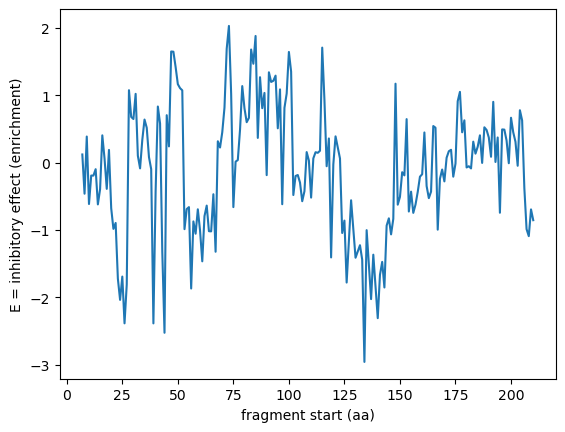

In [10]:
sns.lineplot(data=exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)],
            x='fragment start (aa)',y='E = inhibitory effect (enrichment)')

<AxesSubplot:xlabel='E = inhibitory effect (enrichment)', ylabel='Count'>

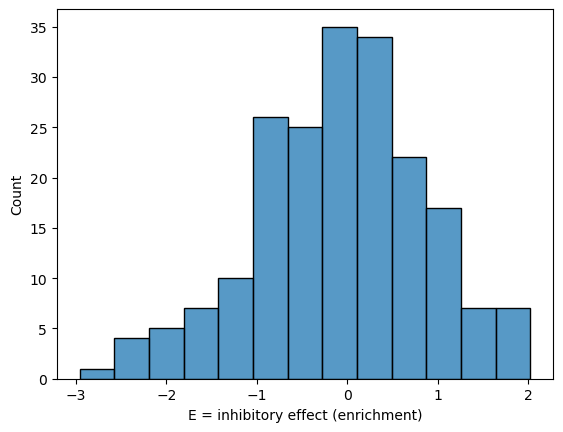

In [11]:
sns.histplot(data=exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)],
                x='E = inhibitory effect (enrichment)')

<AxesSubplot:ylabel='E = inhibitory effect (enrichment)'>

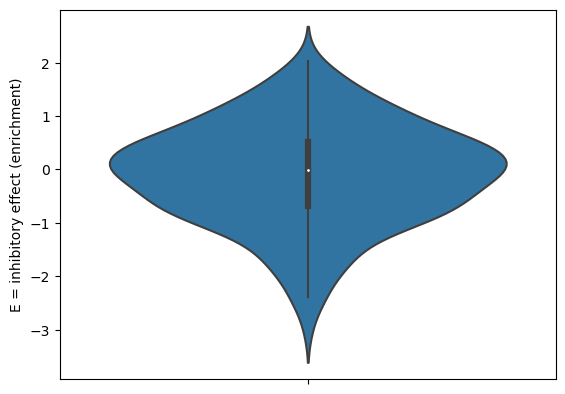

In [12]:
sns.violinplot(data=exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)],
                y='E = inhibitory effect (enrichment)')

In [13]:
exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)]['E = inhibitory effect (enrichment)'].mean()

-0.08494824838

In [14]:
exp_df[(exp_df['gene']=='EGFP-coding-pEGFP')&(exp_df['fragment length (aa)']==30)]['E = inhibitory effect (enrichment)'].var()

0.8895401635776445

# Call peaks in FtsZ

In [15]:
df.gene.unique()

array(['folA-coding-EcoliBL21DE3', 'ftsZ-coding-EcoliBL21DE3',
       'groL-coding-EcoliBL21DE3', 'gyrA-coding-EcoliBL21DE3',
       'lptG-coding-EcoliBL21DE3', 'rpIL-coding-EcoliBL21DE3',
       'ssb-coding-EcoliBL21DE3'], dtype=object)

In [16]:
df[df['gene']=='ftsZ-coding-EcoliBL21DE3']

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,gene,condition
124,FtsZ_10-316_FtsZ_1-30,1,15.5,30,0.174501,72.288333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.523504,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
125,FtsZ_10-316_FtsZ_2-31,2,16.5,31,0.539908,82.679000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.239451,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
126,FtsZ_10-316_FtsZ_3-32,3,17.5,32,0.456218,80.927667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.824871,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
127,FtsZ_10-316_FtsZ_4-33,4,18.5,33,0.479033,83.006667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.916134,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
128,FtsZ_10-316_FtsZ_5-34,5,19.5,34,0.436050,82.282667,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.308149,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
...,...,...,...,...,...,...,...,...,...,...,...,...
472,FtsZ_10-316_FtsZ_349-378,349,363.5,378,0.095820,35.024333,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
473,FtsZ_10-316_FtsZ_350-379,350,364.5,379,0.110646,37.216667,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.221292,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
474,FtsZ_10-316_FtsZ_351-380,351,365.5,380,0.096198,38.402000,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.384792,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ
475,FtsZ_10-316_FtsZ_352-381,352,366.5,381,0.273637,46.714667,12,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.283643,ftsZ-coding-EcoliBL21DE3,30aa_monomer_fstZ


<AxesSubplot:xlabel='fragment start (aa)', ylabel='E = inhibitory effect (enrichment)'>

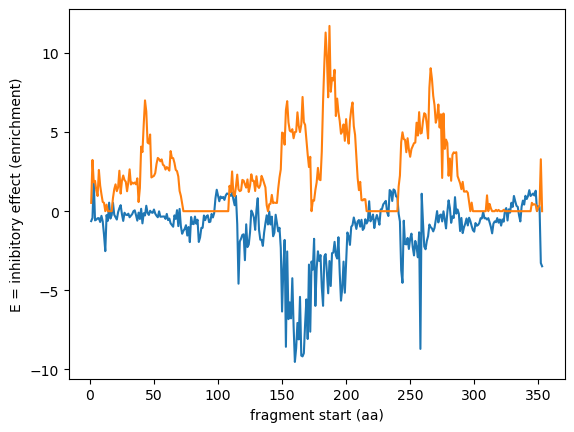

In [17]:
sns.lineplot(data=merge_df[merge_df['gene']=='ftsZ-coding-EcoliBL21DE3'],x='fragment start (aa)',y='E = inhibitory effect (enrichment)')
sns.lineplot(data=merge_df[merge_df['gene']=='ftsZ-coding-EcoliBL21DE3'],x='fragment start (aa)',y='weighted_contacts')

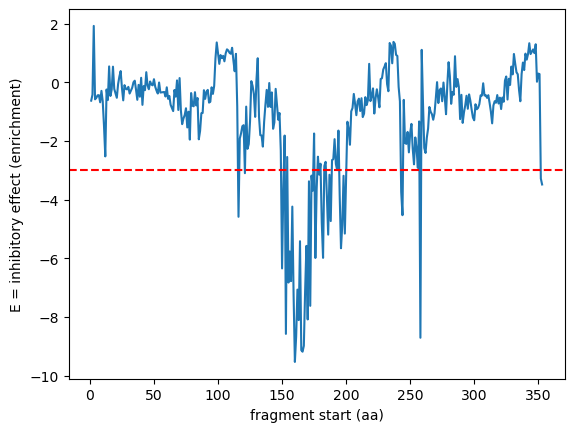

In [18]:
ax = sns.lineplot(data=merge_df[merge_df['gene']=='ftsZ-coding-EcoliBL21DE3'],x='fragment start (aa)',y='E = inhibitory effect (enrichment)')
ax.axhline(-3,c='r',ls='--')

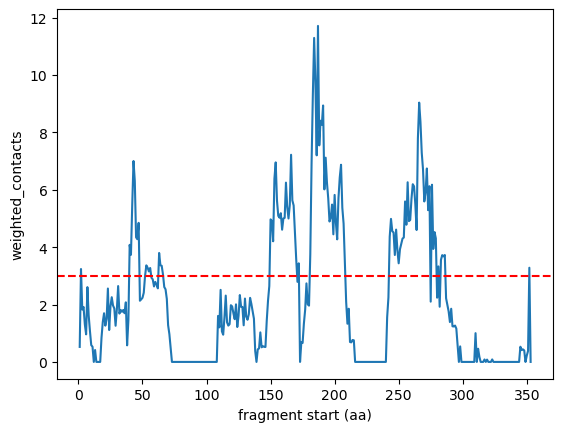

In [19]:
ax = sns.lineplot(data=merge_df[merge_df['gene']=='ftsZ-coding-EcoliBL21DE3'],x='fragment start (aa)',y='weighted_contacts')
ax.axhline(3,c='r',ls='--')

In [20]:
ftsZ_df = merge_df[merge_df['gene']=='ftsZ-coding-EcoliBL21DE3']
ftsZ_df.head()

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
124,FtsZ_10-316_FtsZ_1-30,1,15.5,30,0.174501,72.288333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.523504,...,30.0,-0.626857,0.106985,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
125,FtsZ_10-316_FtsZ_2-31,2,16.5,31,0.539908,82.679000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.239451,...,30.0,-0.422974,0.118667,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
126,FtsZ_10-316_FtsZ_3-32,3,17.5,32,0.456218,80.927667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.824871,...,30.0,1.919863,0.156495,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
127,FtsZ_10-316_FtsZ_4-33,4,18.5,33,0.479033,83.006667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.916134,...,30.0,-0.581484,0.318616,hydrophilic,stable,neutral,1.0,1.0,0.0,N-terminal
128,FtsZ_10-316_FtsZ_5-34,5,19.5,34,0.436050,82.282667,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.308149,...,30.0,-0.532176,0.212105,hydrophobic,stable,neutral,1.0,1.0,0.0,N-terminal


In [21]:
ftsZ_inhib_df = ftsZ_df[ftsZ_df['E = inhibitory effect (enrichment)']<-3.0]
ftsZ_inhib_df

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
239,FtsZ_10-316_FtsZ_116-145,116,130.5,145,0.460443,86.906333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.381328,...,30.0,-4.585132,1.284617,hydrophobic,stable,positive,1.0,1.0,0.0,central
244,FtsZ_10-316_FtsZ_121-150,121,135.5,150,0.423125,86.292667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.692498,...,30.0,-3.099130,0.599563,hydrophobic,stable,positive,1.0,1.0,0.0,central
273,FtsZ_10-316_FtsZ_150-179,150,164.5,179,0.621360,86.323000,8,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.970883,...,30.0,-6.345395,1.614052,hydrophobic,stable,positive,1.0,1.0,0.0,central
274,FtsZ_10-316_FtsZ_151-180,151,165.5,180,0.614655,85.376667,8,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.917237,...,30.0,-3.621549,0.357520,hydrophobic,stable,neutral,1.0,1.0,0.0,central
276,FtsZ_10-316_FtsZ_153-182,153,167.5,182,0.639112,83.554333,10,/data1/groups/keatinglab/swans/savinovCollabor...,both,6.391124,...,30.0,-8.575897,1.370925,hydrophobic,stable,positive,1.0,1.0,0.0,central
278,FtsZ_10-316_FtsZ_155-184,155,169.5,184,0.702631,83.696667,8,/data1/groups/keatinglab/swans/savinovCollabor...,both,5.621045,...,30.0,-6.826763,1.928687,hydrophobic,stable,positive,1.0,1.0,0.0,central
279,FtsZ_10-316_FtsZ_156-185,156,170.5,185,0.727599,83.990333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,5.093196,...,30.0,-5.767311,0.881639,hydrophobic,stable,neutral,1.0,1.0,0.0,central
280,FtsZ_10-316_FtsZ_157-186,157,171.5,186,0.718071,83.525333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,5.026497,...,30.0,-6.777807,1.429465,hydrophobic,stable,neutral,1.0,1.0,0.0,central
281,FtsZ_10-316_FtsZ_158-187,158,172.5,187,0.740859,84.426000,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,5.186012,...,30.0,-4.238363,0.438521,hydrophobic,stable,negative,1.0,1.0,0.0,central
282,FtsZ_10-316_FtsZ_159-188,159,173.5,188,0.658612,80.355667,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.610284,...,30.0,-7.251989,0.908683,hydrophobic,stable,neutral,1.0,1.0,0.0,central


# Cluster inhibitory peaks by contacts

FtsZ_10-316_FtsZ_116-145 116
FtsZ_10-316_FtsZ_121-150 121
FtsZ_10-316_FtsZ_150-179 150
FtsZ_10-316_FtsZ_151-180 151
FtsZ_10-316_FtsZ_153-182 153
FtsZ_10-316_FtsZ_155-184 155
FtsZ_10-316_FtsZ_156-185 156
FtsZ_10-316_FtsZ_157-186 157
FtsZ_10-316_FtsZ_158-187 158
FtsZ_10-316_FtsZ_159-188 159
FtsZ_10-316_FtsZ_160-189 160
FtsZ_10-316_FtsZ_161-190 161
FtsZ_10-316_FtsZ_162-191 162
FtsZ_10-316_FtsZ_163-192 163
FtsZ_10-316_FtsZ_164-193 164
FtsZ_10-316_FtsZ_165-194 165
FtsZ_10-316_FtsZ_166-195 166
FtsZ_10-316_FtsZ_167-196 167
FtsZ_10-316_FtsZ_168-197 168
FtsZ_10-316_FtsZ_169-198 169
FtsZ_10-316_FtsZ_170-199 170
FtsZ_10-316_FtsZ_171-200 171
FtsZ_10-316_FtsZ_172-201 172
FtsZ_10-316_FtsZ_173-202 173
FtsZ_10-316_FtsZ_174-203 174
FtsZ_10-316_FtsZ_176-205 176
FtsZ_10-316_FtsZ_177-206 177
FtsZ_10-316_FtsZ_179-208 179
FtsZ_10-316_FtsZ_181-210 181
FtsZ_10-316_FtsZ_182-211 182
FtsZ_10-316_FtsZ_185-214 185
FtsZ_10-316_FtsZ_186-215 186
FtsZ_10-316_FtsZ_187-216 187
FtsZ_10-316_FtsZ_188-217 188
FtsZ_10-316_Ft

Text(95.72222222222221, 0.5, 'fragment start (aa)')

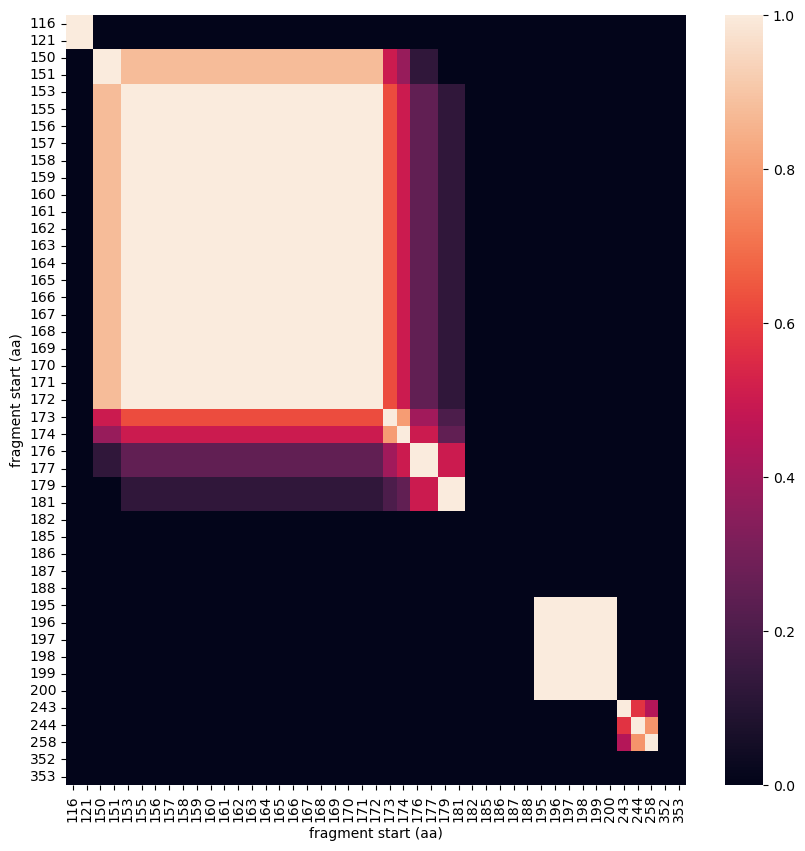

In [160]:
# Get the contact info for each fragment
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/6UNX_asymUnitCopied_A_B_C.pdb'
interface_contacts_list = []
for i,row in ftsZ_inhib_df.iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'A' if row['fragment start (aa)'] > 190 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)']),'B':resRange()})
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{fragment_chain_id},{'B'},4.0)
    interface_contacts_list.append([residueContactName(x,y) for x,y in contacts_residues])
    
# create a similarity matrix
sim_list = []
for frag_contacts_a in interface_contacts_list:
    for frag_contacts_b in interface_contacts_list:
        sim_list.append(contactOverlap(frag_contacts_a,frag_contacts_b))
        
sim_matrix = np.array(sim_list).reshape(len(interface_contacts_list),len(interface_contacts_list))
plt.figure(figsize = (10,10))
ax = sns.heatmap(sim_matrix,
            xticklabels=ftsZ_inhib_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df['fragment start (aa)'])
ax.set_xlabel('fragment start (aa)')
ax.set_ylabel('fragment start (aa)')
# plt.savefig('230128_contactsim_fragmentswenrichmentlessthanneg3_6unx.png',dpi=300)

FtsZ_10-316_FtsZ_116-145 116
FtsZ_10-316_FtsZ_121-150 121
FtsZ_10-316_FtsZ_150-179 150
FtsZ_10-316_FtsZ_151-180 151
FtsZ_10-316_FtsZ_153-182 153
FtsZ_10-316_FtsZ_155-184 155
FtsZ_10-316_FtsZ_156-185 156
FtsZ_10-316_FtsZ_157-186 157
FtsZ_10-316_FtsZ_158-187 158
FtsZ_10-316_FtsZ_159-188 159
FtsZ_10-316_FtsZ_160-189 160
FtsZ_10-316_FtsZ_161-190 161
FtsZ_10-316_FtsZ_162-191 162
FtsZ_10-316_FtsZ_163-192 163
FtsZ_10-316_FtsZ_164-193 164
FtsZ_10-316_FtsZ_165-194 165
FtsZ_10-316_FtsZ_166-195 166
FtsZ_10-316_FtsZ_167-196 167
FtsZ_10-316_FtsZ_168-197 168
FtsZ_10-316_FtsZ_169-198 169
FtsZ_10-316_FtsZ_170-199 170
FtsZ_10-316_FtsZ_171-200 171
FtsZ_10-316_FtsZ_172-201 172
FtsZ_10-316_FtsZ_173-202 173
FtsZ_10-316_FtsZ_174-203 174
FtsZ_10-316_FtsZ_176-205 176
FtsZ_10-316_FtsZ_177-206 177
FtsZ_10-316_FtsZ_179-208 179
FtsZ_10-316_FtsZ_181-210 181
FtsZ_10-316_FtsZ_182-211 182
FtsZ_10-316_FtsZ_185-214 185
FtsZ_10-316_FtsZ_186-215 186
FtsZ_10-316_FtsZ_187-216 187
FtsZ_10-316_FtsZ_188-217 188
FtsZ_10-316_Ft

Text(95.72222222222221, 0.5, 'fragment start (aa)')

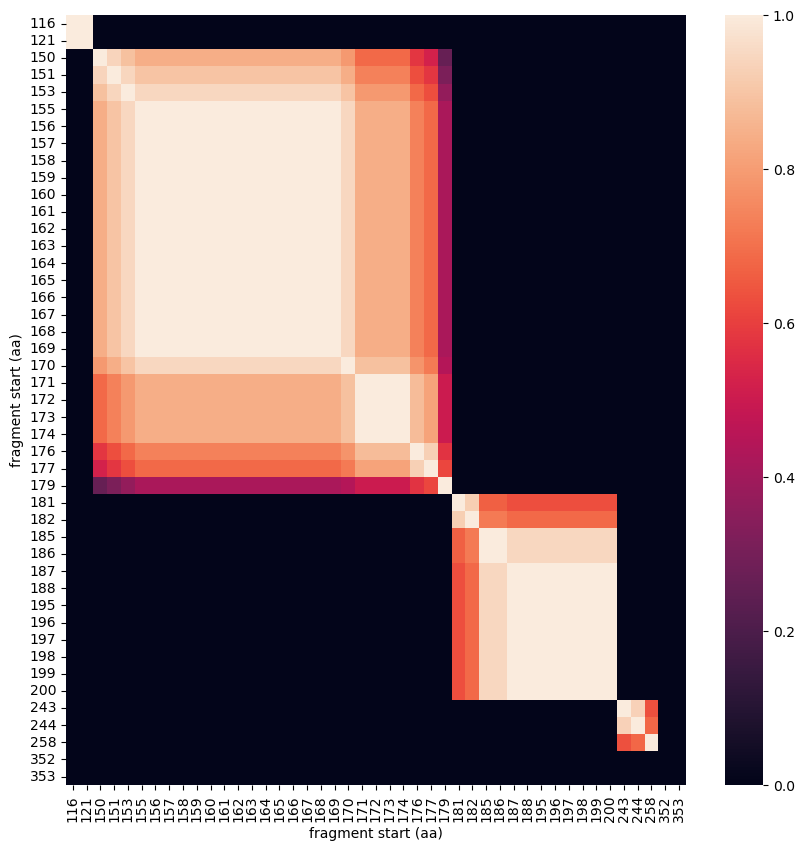

In [172]:
# Get the contact info for each fragment
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/3VOA_asymUnitCopied_A_BC.pdb'
interface_contacts_list = []
for i,row in ftsZ_inhib_df.iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'B' if row['fragment start (aa)'] > 180 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)']),'A':resRange()})
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{fragment_chain_id},4.0)
    interface_contacts_list.append(contacts_residues)
    
# create a similarity matrix
sim_list = []
for frag_contacts_a in interface_contacts_list:
    for frag_contacts_b in interface_contacts_list:
        sim_list.append(contactOverlap(frag_contacts_a,frag_contacts_b))
        
sim_matrix = np.array(sim_list).reshape(len(interface_contacts_list),len(interface_contacts_list))
plt.figure(figsize = (10,10))
ax = sns.heatmap(sim_matrix,
            xticklabels=ftsZ_inhib_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df['fragment start (aa)'])
ax.set_xlabel('fragment start (aa)')
ax.set_ylabel('fragment start (aa)')
# plt.savefig('230128_contactsim_fragmentswenrichmentlessthanneg3_6unx.png',dpi=300)

FtsZ_10-316_FtsZ_116-145 116 /data1/groups/keatinglab/swans/savinovCollaboration/ftsZ/data/221111_colabfold/data/FtsZ_10-316_FtsZ_116-145/output/FtsZ_10-316_FtsZ_116-145_unrelaxed_rank_1_model_4.pdb
FtsZ_10-316_FtsZ_121-150 121 /data1/groups/keatinglab/swans/savinovCollaboration/ftsZ/data/221111_colabfold/data/FtsZ_10-316_FtsZ_121-150/output/FtsZ_10-316_FtsZ_121-150_unrelaxed_rank_1_model_4.pdb
FtsZ_10-316_FtsZ_150-179 150 /data1/groups/keatinglab/swans/savinovCollaboration/ftsZ/data/221111_colabfold/data/FtsZ_10-316_FtsZ_150-179/output/FtsZ_10-316_FtsZ_150-179_unrelaxed_rank_1_model_4.pdb
FtsZ_10-316_FtsZ_151-180 151 /data1/groups/keatinglab/swans/savinovCollaboration/ftsZ/data/221111_colabfold/data/FtsZ_10-316_FtsZ_151-180/output/FtsZ_10-316_FtsZ_151-180_unrelaxed_rank_1_model_4.pdb
FtsZ_10-316_FtsZ_153-182 153 /data1/groups/keatinglab/swans/savinovCollaboration/ftsZ/data/221111_colabfold/data/FtsZ_10-316_FtsZ_153-182/output/FtsZ_10-316_FtsZ_153-182_unrelaxed_rank_1_model_4.pdb
FtsZ_

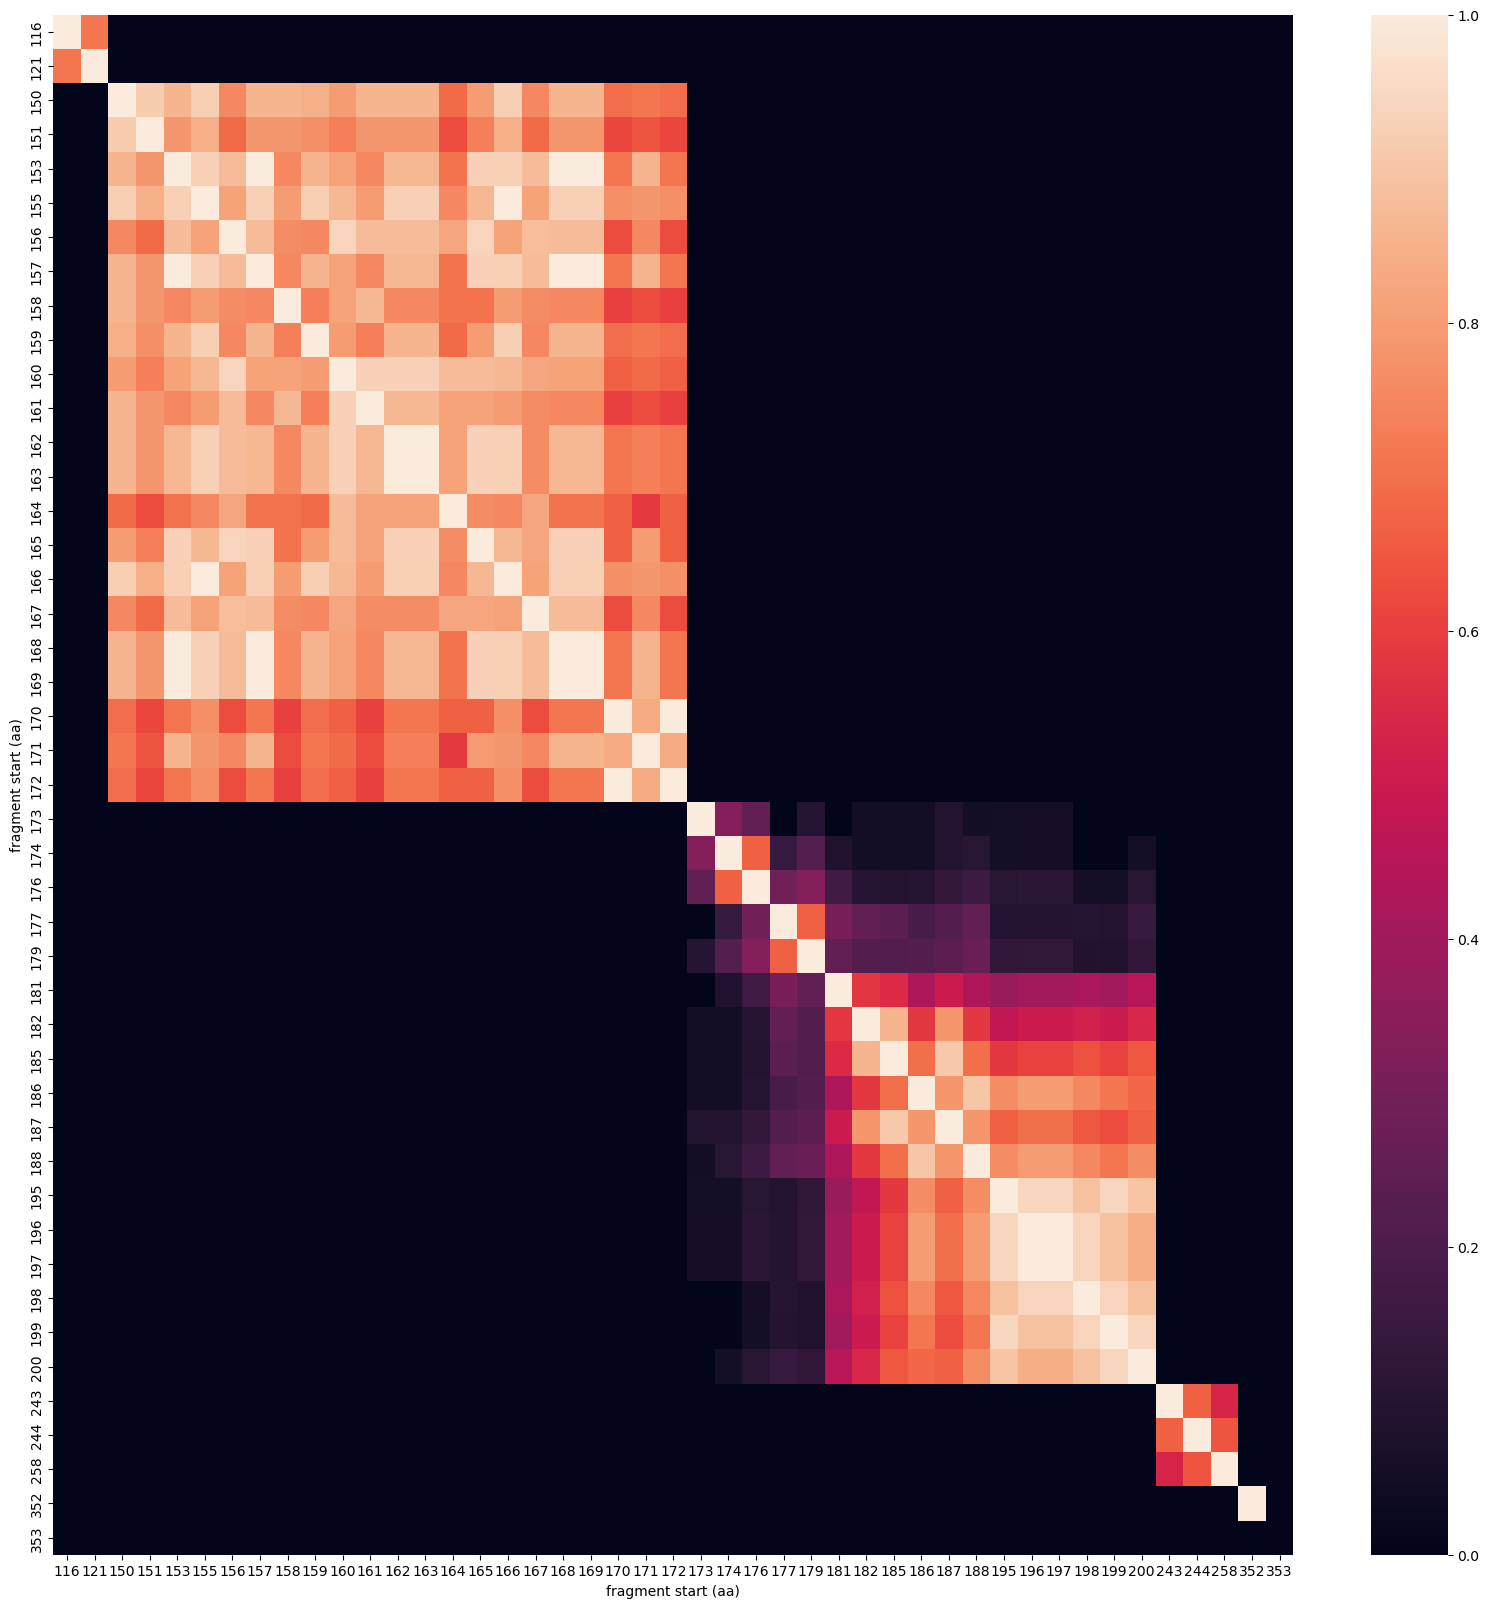

In [161]:
# Get the contact info for each fragment
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/6UNX_asymUnitCopied_A_B_C.pdb'
interface_contacts_list = []
parser = PDBParser(QUIET=True)
for i,row in ftsZ_inhib_df.iterrows():
    print(row['fragment_name'],row['fragment start (aa)'],row['path'])
    s_extract = parser.get_structure("s", row['path'])
    fixResidueNumbers(s_extract[0]['B'],row['fragment start (aa)'])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    interface_contacts_list.append([residueContactName(x,y) for x,y in contacts_residues])
    
# create a similarity matrix
sim_list = []
for frag_contacts_a in interface_contacts_list:
    for frag_contacts_b in interface_contacts_list:
        sim_list.append(contactOverlap(frag_contacts_a,frag_contacts_b))
        
sim_matrix = np.array(sim_list).reshape(len(interface_contacts_list),len(interface_contacts_list))
plt.figure(figsize = (20,20))
ax = sns.heatmap(sim_matrix,
            xticklabels=ftsZ_inhib_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df['fragment start (aa)'])
ax.set_xlabel('fragment start (aa)')
ax.set_ylabel('fragment start (aa)')
plt.savefig('230128_fstZ_contactsim_fragmentswenrichmentlessthanneg3_6unx.png',dpi=300)

# Determine if ftsZ peaks are predicted by weighted contacts

In [27]:
# First, use Andrew's definitions for inhibitory fragments
ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])]

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
239,FtsZ_10-316_FtsZ_116-145,116,130.5,145,0.460443,86.906333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.381328,...,30.0,-4.585132,1.284617,hydrophobic,stable,positive,1.0,1.0,0.0,central
286,FtsZ_10-316_FtsZ_163-192,163,177.5,192,0.771247,83.920000,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,5.398732,...,30.0,-8.105527,1.006710,hydrophobic,stable,neutral,1.0,1.0,0.0,central
309,FtsZ_10-316_FtsZ_186-215,186,200.5,215,0.654787,77.537000,11,/data1/groups/keatinglab/swans/savinovCollabor...,both,7.202657,...,30.0,-5.193066,0.811929,hydrophobic,stable,neutral,1.0,0.0,0.0,central
381,FtsZ_10-316_FtsZ_258-287,258,272.5,287,0.818230,86.583333,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.909382,...,30.0,-8.707761,1.176845,hydrophobic,stable,neutral,1.0,1.0,0.0,C-terminal


For each fragment:
1. Get the contacts
2. Compare to the contacts of all of the predicted inhibitory fragments (anything with weighted contacts >= 1)
3. Predicted if inhibitory fragment has at least 50% of contacts (report the prediction with highest similarity)

In [120]:
fstZ_pred_df = ftsZ_df[ftsZ_df['weighted_contacts']>=1.5].copy(deep=True)
print(f"predicted {len(fstZ_pred_df)} inhibitory fragments")
contacts_list = []

for i,row in fstZ_pred_df.iterrows():
    s_extract = parser.get_structure("s", row['path'])
    fixResidueNumbers(s_extract[0]['A'],10)
    fixResidueNumbers(s_extract[0]['B'],row['fragment start (aa)'])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    print(f"pred fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
    contacts_list.append(contacts_residues)
fstZ_pred_df['contact_set'] = contacts_list
fstZ_pred_df

predicted 179 inhibitory fragments
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts
pred fragment FtsZ_10-316_FtsZ_31-60 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_32-61 has 5 contacts
pred fragment FtsZ_10-316_FtsZ_33-62 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_34-63 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_35-64 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_36

pred fragment FtsZ_10-316_FtsZ_267-296 has 23 contacts
pred fragment FtsZ_10-316_FtsZ_268-297 has 20 contacts
pred fragment FtsZ_10-316_FtsZ_269-298 has 18 contacts
pred fragment FtsZ_10-316_FtsZ_270-299 has 15 contacts
pred fragment FtsZ_10-316_FtsZ_271-300 has 24 contacts
pred fragment FtsZ_10-316_FtsZ_272-301 has 17 contacts
pred fragment FtsZ_10-316_FtsZ_273-302 has 16 contacts
pred fragment FtsZ_10-316_FtsZ_274-303 has 15 contacts
pred fragment FtsZ_10-316_FtsZ_275-304 has 10 contacts
pred fragment FtsZ_10-316_FtsZ_276-305 has 15 contacts
pred fragment FtsZ_10-316_FtsZ_277-306 has 12 contacts
pred fragment FtsZ_10-316_FtsZ_278-307 has 13 contacts
pred fragment FtsZ_10-316_FtsZ_279-308 has 14 contacts
pred fragment FtsZ_10-316_FtsZ_280-309 has 8 contacts
pred fragment FtsZ_10-316_FtsZ_281-310 has 10 contacts
pred fragment FtsZ_10-316_FtsZ_282-311 has 6 contacts
pred fragment FtsZ_10-316_FtsZ_283-312 has 8 contacts
pred fragment FtsZ_10-316_FtsZ_284-313 has 9 contacts
pred fragment 

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier,contact_set
125,FtsZ_10-316_FtsZ_2-31,2,16.5,31,0.539908,82.679000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.239451,...,-0.422974,0.118667,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
126,FtsZ_10-316_FtsZ_3-32,3,17.5,32,0.456218,80.927667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.824871,...,1.919863,0.156495,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
127,FtsZ_10-316_FtsZ_4-33,4,18.5,33,0.479033,83.006667,4,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.916134,...,-0.581484,0.318616,hydrophilic,stable,neutral,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
130,FtsZ_10-316_FtsZ_7-36,7,21.5,36,0.521556,85.120000,5,/data1/groups/keatinglab/swans/savinovCollabor...,both,2.607782,...,-0.439665,0.143332,hydrophobic,stable,neutral,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
131,FtsZ_10-316_FtsZ_8-37,8,22.5,37,0.539845,87.488667,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.619534,...,-0.683129,0.121722,hydrophobic,stable,neutral,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,FtsZ_10-316_FtsZ_287-316,287,301.5,316,0.740415,83.831333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,2.221245,...,0.107950,0.068876,hydrophobic,stable,negative,0.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
411,FtsZ_10-316_FtsZ_288-317,288,302.5,317,0.664062,82.701333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.992187,...,-0.158747,0.175440,hydrophobic,stable,negative,0.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
412,FtsZ_10-316_FtsZ_289-318,289,303.5,318,0.586925,82.368333,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.760776,...,-1.256662,0.387794,hydrophobic,stable,negative,0.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."
414,FtsZ_10-316_FtsZ_291-320,291,305.5,320,0.617990,79.930000,3,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.853970,...,-1.384924,0.457404,hydrophobic,stable,negative,0.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <..."


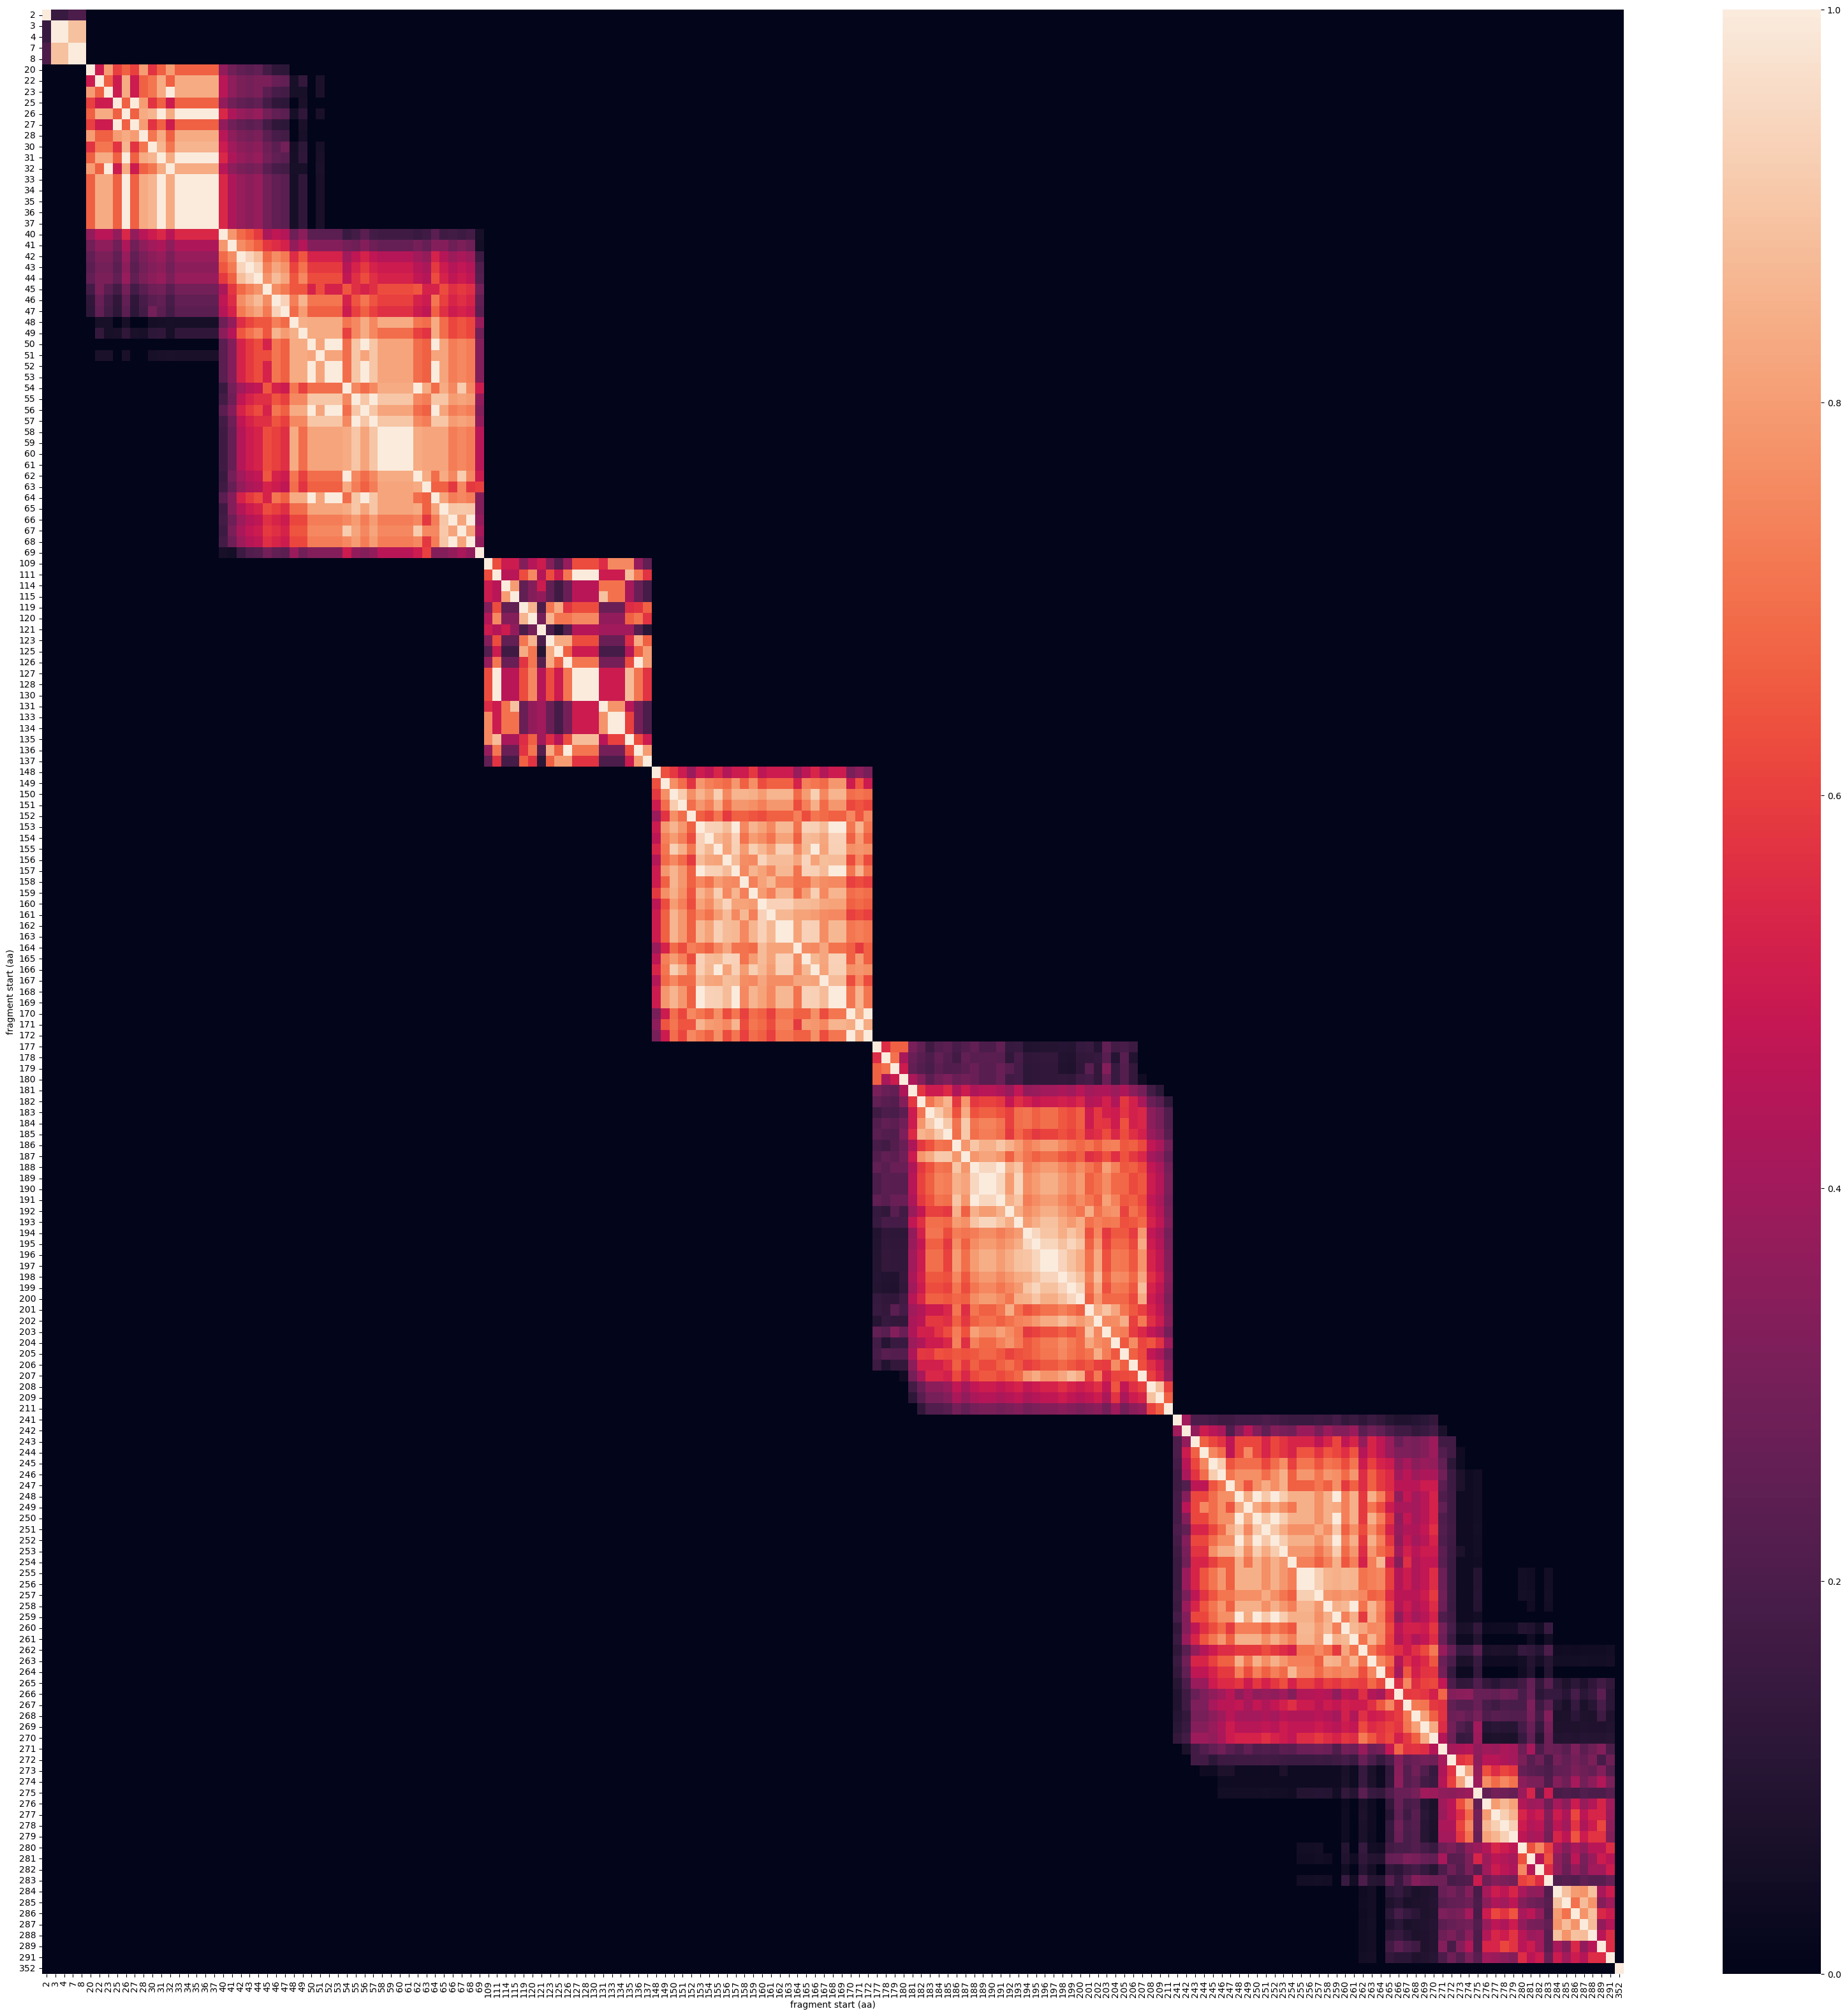

In [162]:
# create a similarity matrix
sim_list = []
for frag_contacts_a in fstZ_pred_df['contact_set']:
    for frag_contacts_b in fstZ_pred_df['contact_set']:
        sim_list.append(contactOverlap(frag_contacts_a,frag_contacts_b))
        
sim_matrix = np.array(sim_list).reshape(len(fstZ_pred_df['contact_set']),len(fstZ_pred_df['contact_set']))
plt.figure(figsize = (40,40))
ax = sns.heatmap(sim_matrix,
            xticklabels=fstZ_pred_df['fragment start (aa)'],
            yticklabels=fstZ_pred_df['fragment start (aa)'])
ax.set_xlabel('fragment start (aa)')
ax.set_ylabel('fragment start (aa)')
plt.savefig('230128_fstZ_contactsim_fragments1.5weightedcontacts_6unx.png',dpi=300)

FtsZ_10-316_FtsZ_116-145 116
experimental fragment FtsZ_10-316_FtsZ_116-145 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 s

experimental fragment FtsZ_10-316_FtsZ_163-192 has 8 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 similarity
pred fragment FtsZ_

experimental fragment FtsZ_10-316_FtsZ_258-287 has 9 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 similarity
pred fragment FtsZ_

<AxesSubplot:>

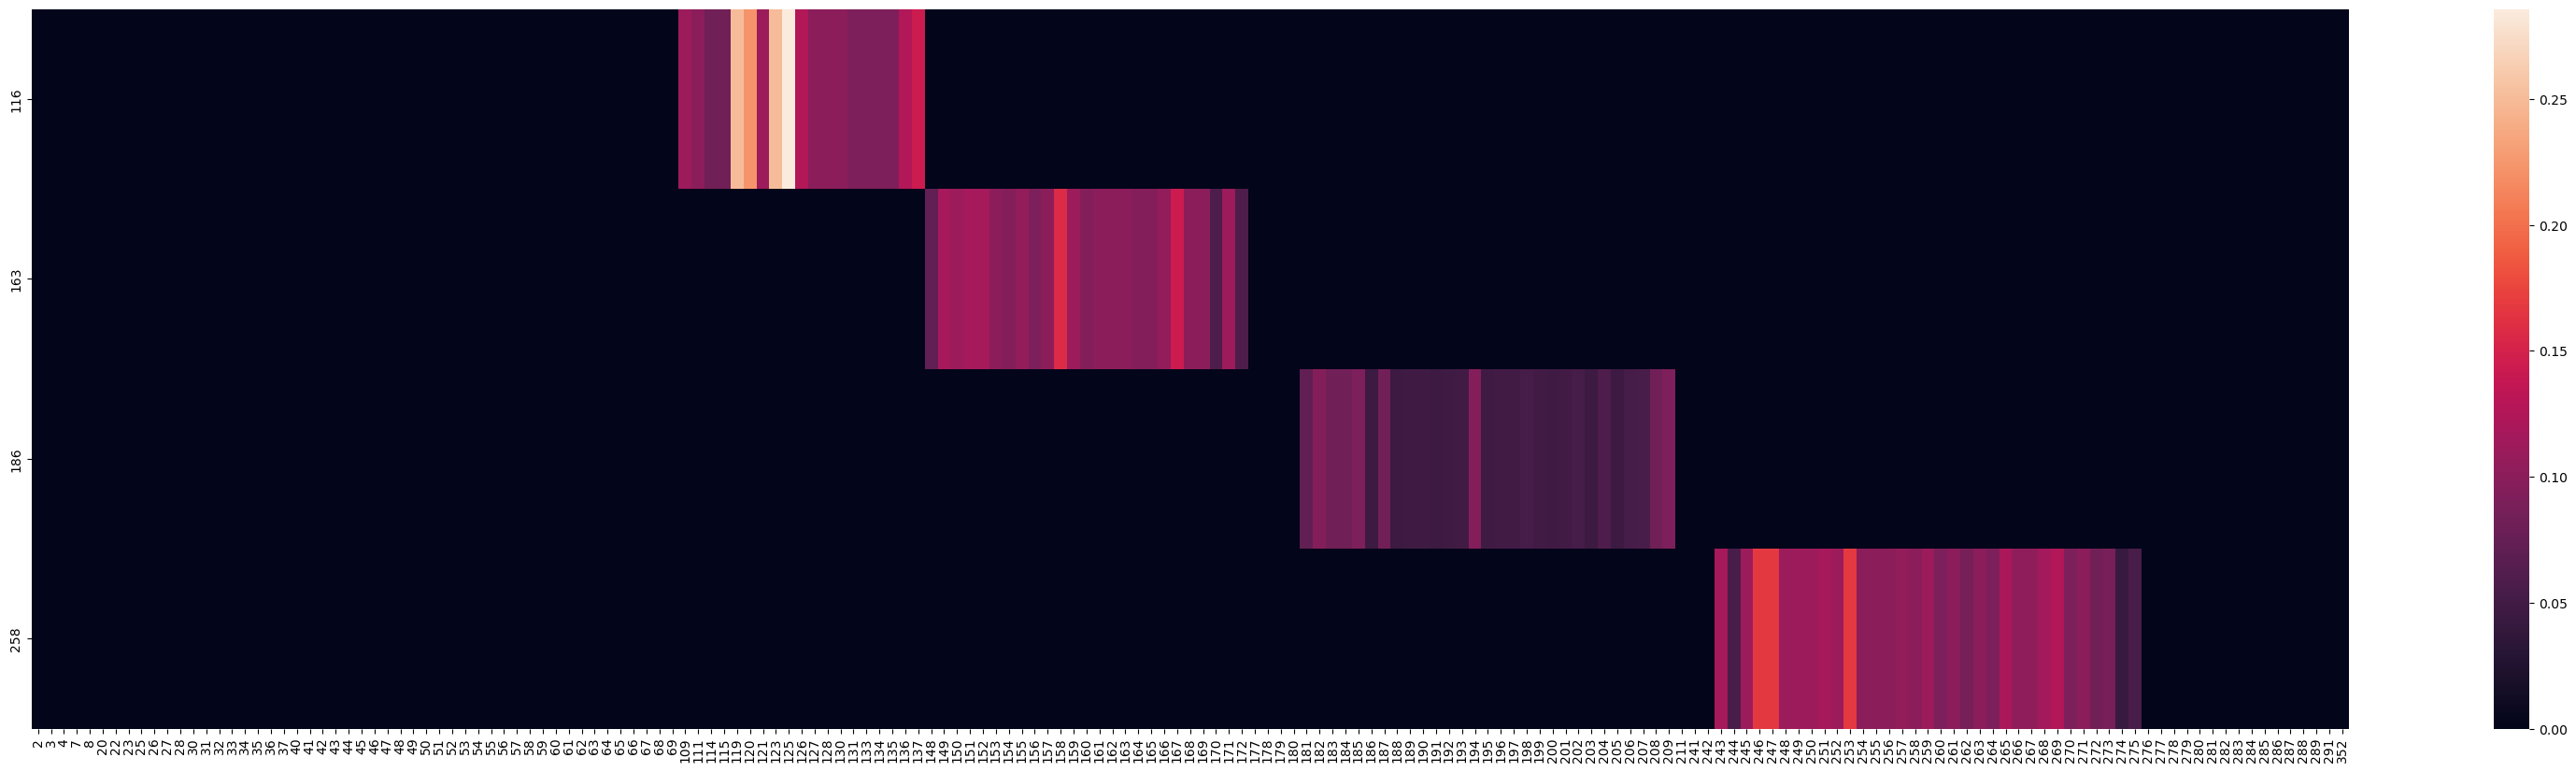

In [180]:
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/6UNX_asymUnitCopied_A_BC.pdb'
ftsZ_pred_df = ftsZ_df[ftsZ_df['weighted_contacts']>=3.0]

sim_list = []
for i,row in ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])].iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'B' if row['fragment start (aa)'] > 180 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{'A':resRange(),fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)'])})
#     print([x for x in s_extract.get_chains()])
    if fragment_chain_id != 'B':
        s_extract[0][fragment_chain_id].id = 'B'
#     print([x for x in s_extract.get_chains()])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    print(f"experimental fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
    for j,row_pred in fstZ_pred_df.iterrows():
        sim = contactOverlap(contacts_residues,row_pred['contact_set'])
        print(f"pred fragment {row_pred['fragment_name']} has {len(row_pred['contact_set'])} contacts and {sim} similarity")
        sim_list.append(sim)

sim_matrix = np.array(sim_list).reshape(4,len(fstZ_pred_df))
plt.figure(figsize = (40,10))
sns.heatmap(sim_matrix,
            xticklabels=fstZ_pred_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])]['fragment start (aa)'])

So it seems like
1. The predicted fragments only share a relatively small number of contacts with the native ones
2. There are multiple fragments that share many contacts (and they're not always neighbors)

This is not unexpected: the fragment could bind in a way that creates many new contacts that did not exist before, for example

FtsZ_10-316_FtsZ_116-145 116
experimental fragment FtsZ_10-316_FtsZ_116-145 has 12 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 

experimental fragment FtsZ_10-316_FtsZ_186-215 has 18 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 similarity
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 similarity
pred fragment FtsZ

<AxesSubplot:>

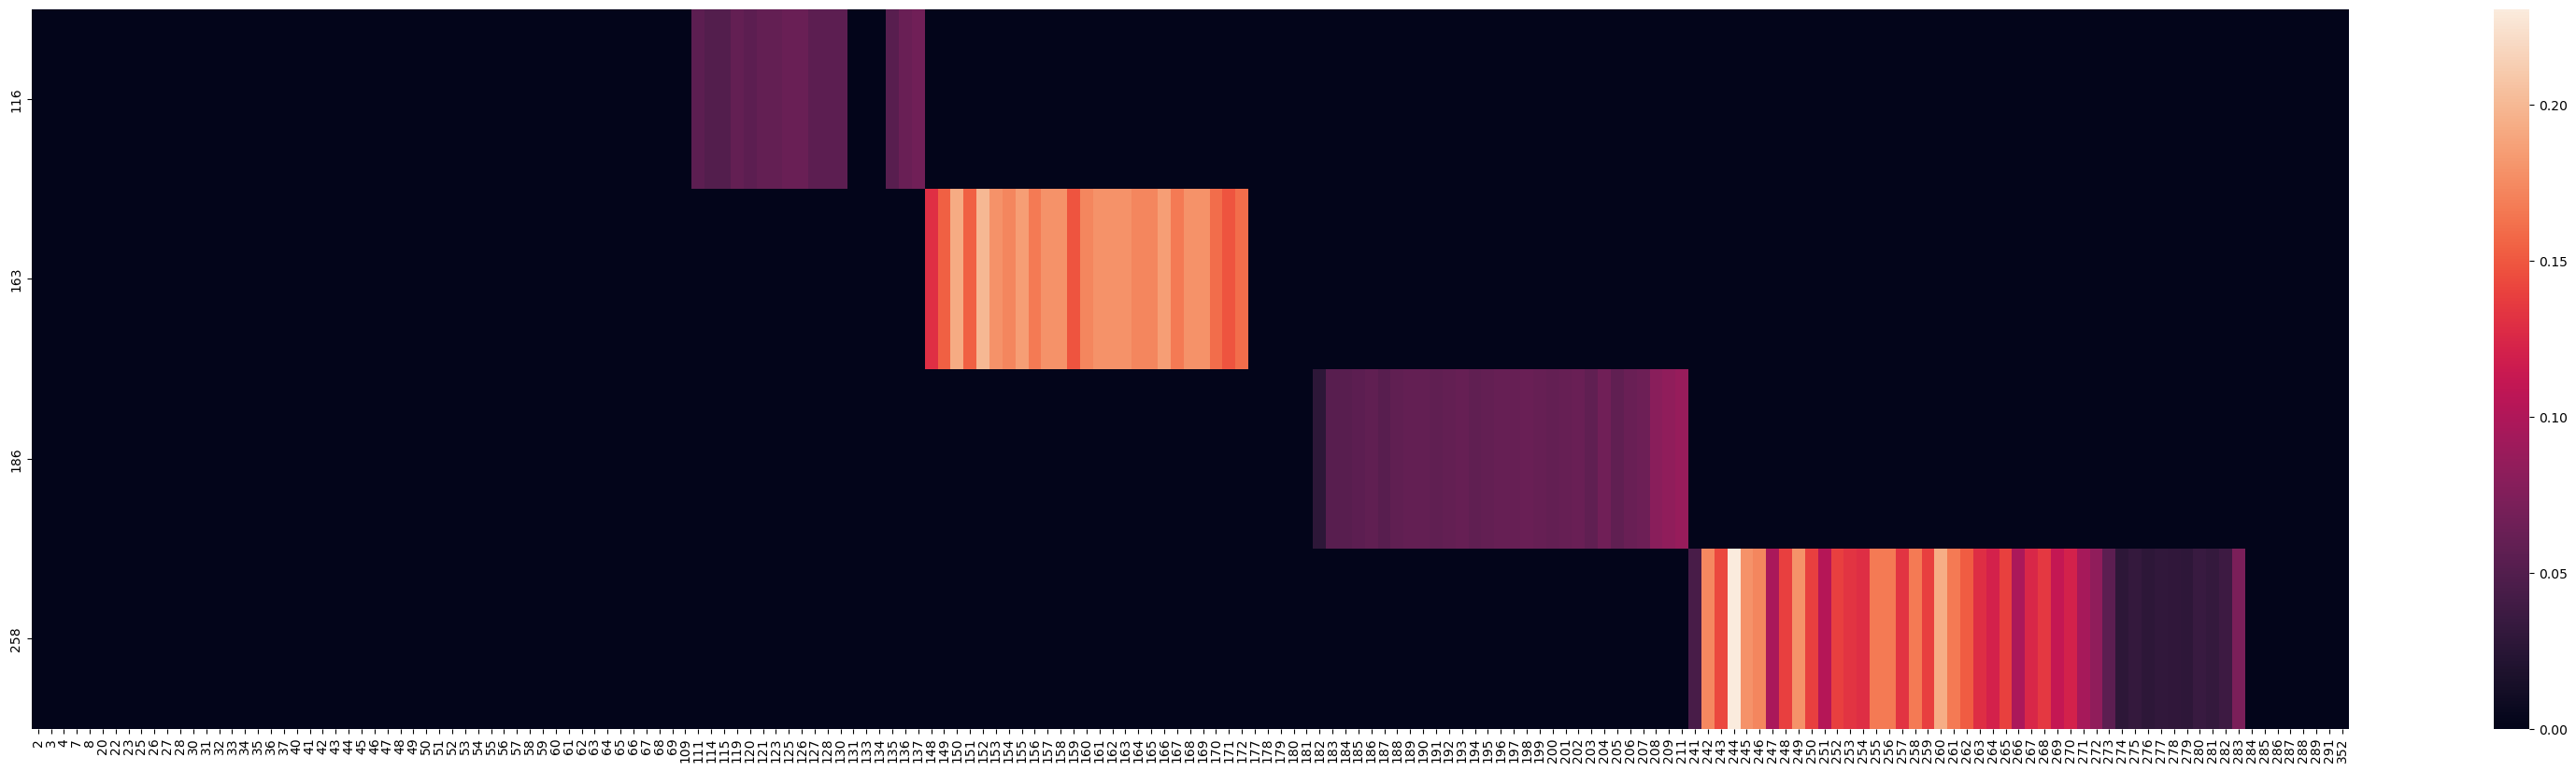

In [182]:
# Check if the other structure (3voa) has better contact overlap
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/3VOA_asymUnitCopied_A_BC.pdb'
ftsZ_pred_df = ftsZ_df[ftsZ_df['weighted_contacts']>=3.0]

sim_list = []
for i,row in ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])].iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'B' if row['fragment start (aa)'] > 180 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{'A':resRange(),fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)'])})
#     print([x for x in s_extract.get_chains()])
    if fragment_chain_id != 'B':
        s_extract[0][fragment_chain_id].id = 'B'
#     print([x for x in s_extract.get_chains()])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    print(f"experimental fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
    for j,row_pred in fstZ_pred_df.iterrows():
        sim = contactOverlap(contacts_residues,row_pred['contact_set'])
        print(f"pred fragment {row_pred['fragment_name']} has {len(row_pred['contact_set'])} contacts and {sim} similarity")
        sim_list.append(sim)

sim_matrix = np.array(sim_list).reshape(4,len(fstZ_pred_df))
plt.figure(figsize = (40,10))
sns.heatmap(sim_matrix,
            xticklabels=fstZ_pred_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])]['fragment start (aa)'])

The second and fourth peaks (starting at 163 and 258) seem to be more like the state in 3voa

# Contact recovery (instead of similarity)

FtsZ_10-316_FtsZ_116-145 116
experimental fragment FtsZ_10-316_FtsZ_116-145 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 recovery
pred fragment Ft

experimental fragment FtsZ_10-316_FtsZ_186-215 has 4 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_31-60 has 6 co

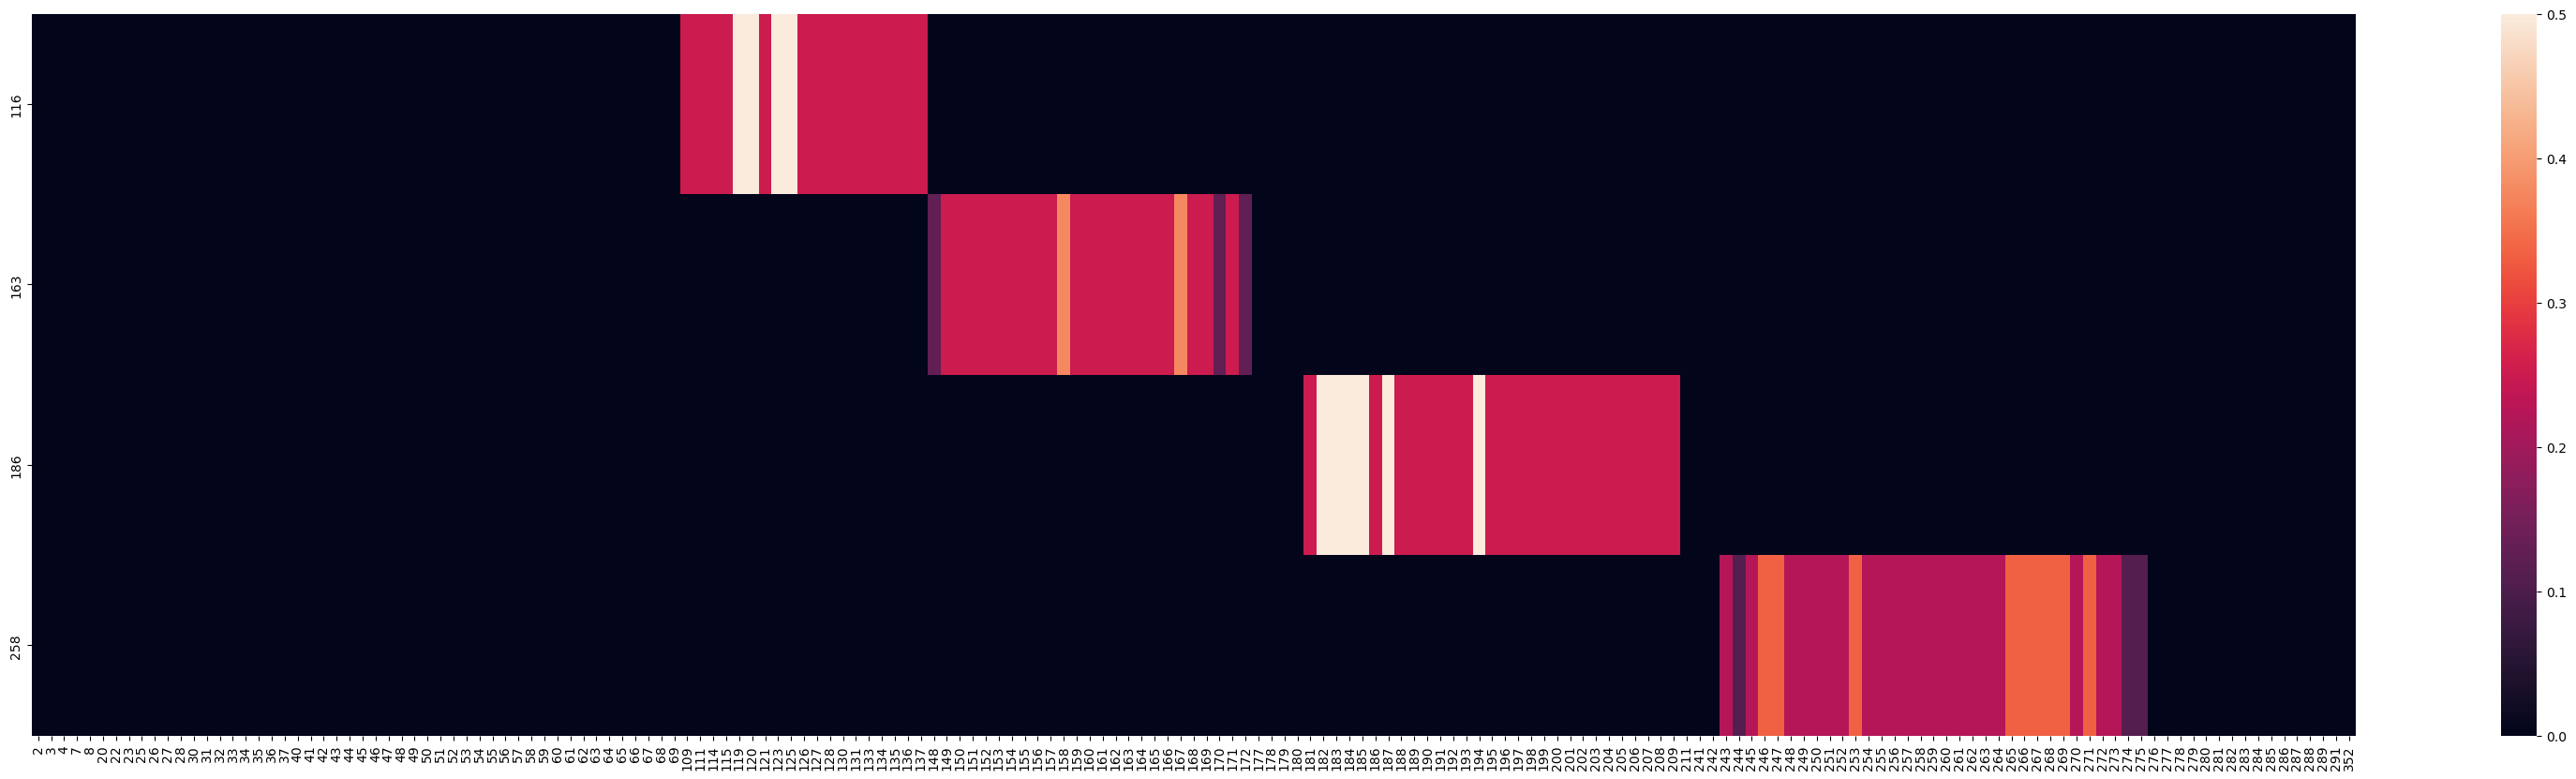

In [183]:
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/6UNX_asymUnitCopied_A_BC.pdb'
ftsZ_pred_df = ftsZ_df[ftsZ_df['weighted_contacts']>=3.0]

rec_list = []
for i,row in ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])].iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'B' if row['fragment start (aa)'] > 180 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{'A':resRange(),fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)'])})
#     print([x for x in s_extract.get_chains()])
    if fragment_chain_id != 'B':
        s_extract[0][fragment_chain_id].id = 'B'
#     print([x for x in s_extract.get_chains()])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    print(f"experimental fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
    for j,row_pred in fstZ_pred_df.iterrows():
        rec = contactsRecovered(contacts_residues,row_pred['contact_set'])
        print(f"pred fragment {row_pred['fragment_name']} has {len(row_pred['contact_set'])} contacts and {rec} recovery")
        rec_list.append(rec)

sim_matrix = np.array(rec_list).reshape(4,len(fstZ_pred_df))
plt.figure(figsize = (40,10))
sns.heatmap(sim_matrix,
            xticklabels=fstZ_pred_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])]['fragment start (aa)'])
plt.savefig('230128_fstZ_contactrecovery_fragments1.5weightedcontacts_6unx.png',dpi=300)

FtsZ_10-316_FtsZ_116-145 116
experimental fragment FtsZ_10-316_FtsZ_116-145 has 12 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 recovery
pred fragment F

experimental fragment FtsZ_10-316_FtsZ_186-215 has 18 contacts
pred fragment FtsZ_10-316_FtsZ_2-31 has 15 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_3-32 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_4-33 has 8 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_7-36 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_8-37 has 9 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_20-49 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_22-51 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_23-52 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_25-54 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_26-55 has 6 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_27-56 has 4 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_28-57 has 5 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_30-59 has 7 contacts and 0.0 recovery
pred fragment FtsZ_10-316_FtsZ_31-60 has 6 c

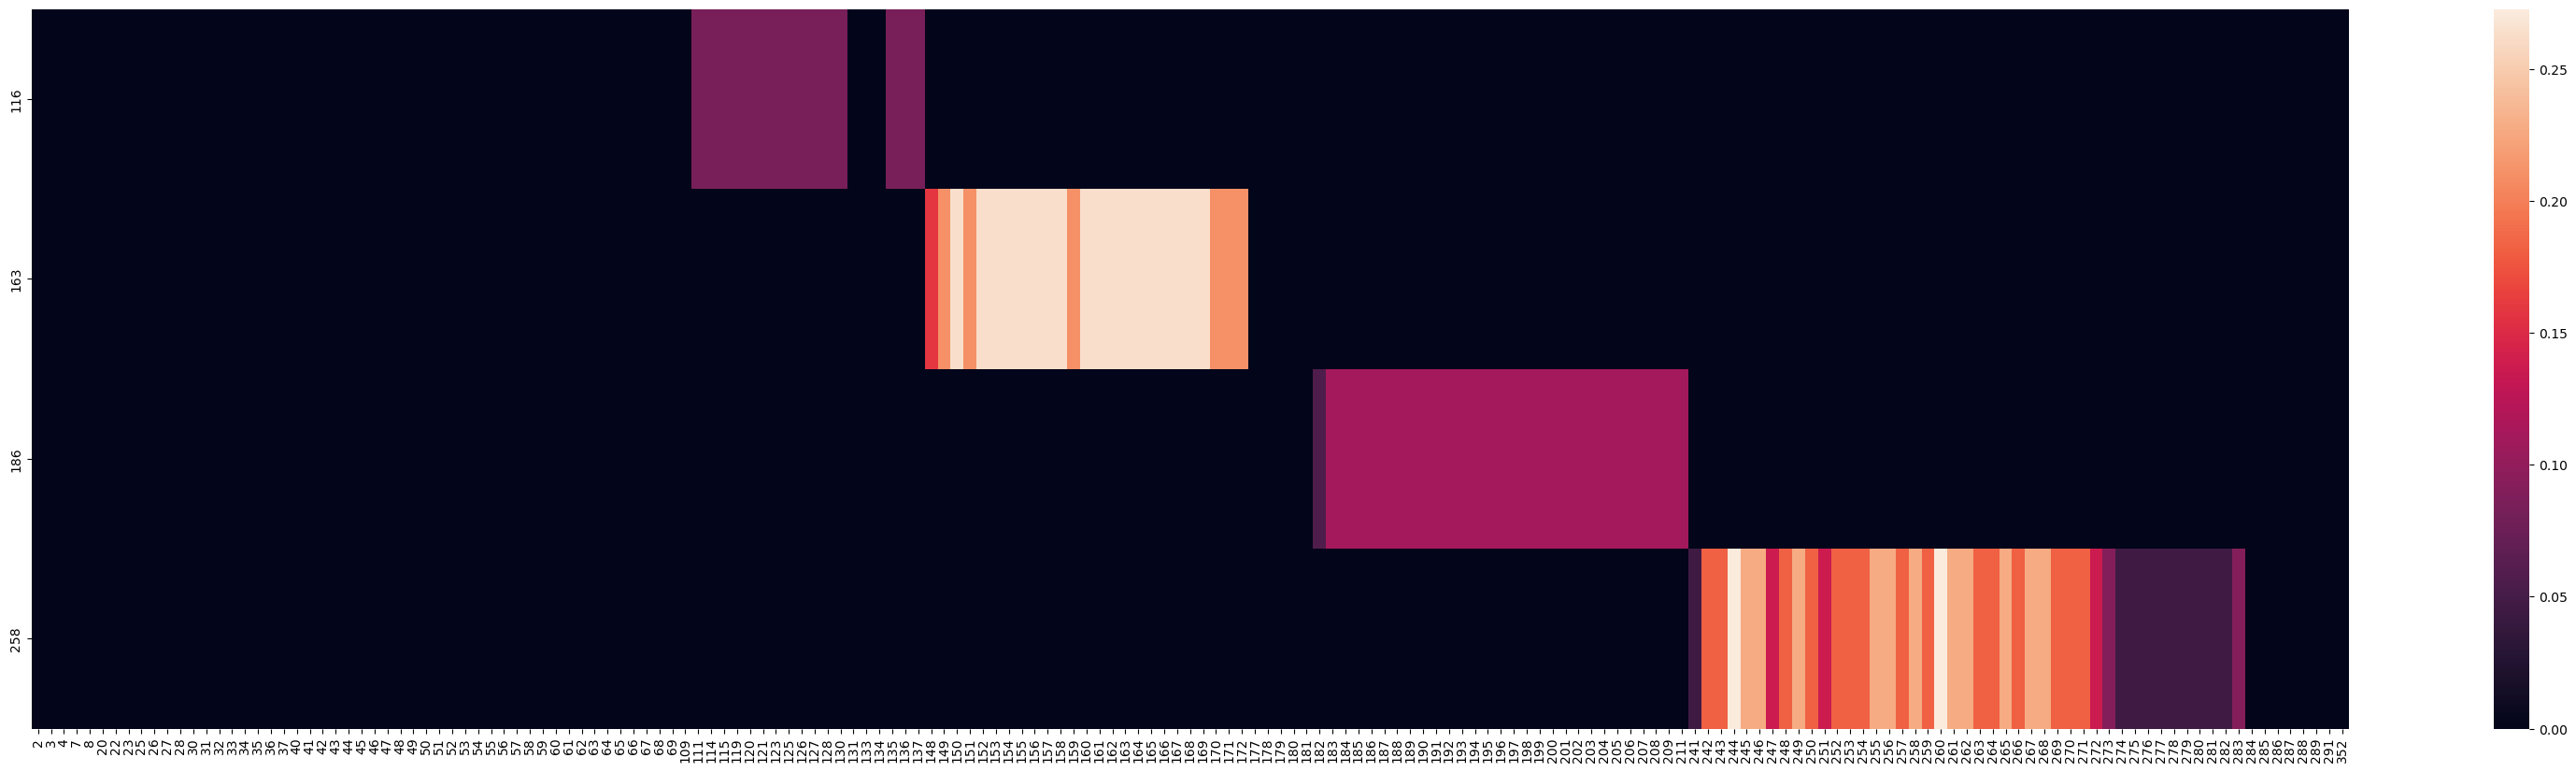

In [184]:
# Check if the other structure (3voa) has better contact overlap
path = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/files/3VOA_asymUnitCopied_A_BC.pdb'
ftsZ_pred_df = ftsZ_df[ftsZ_df['weighted_contacts']>=3.0]

recovery_list = []
for i,row in ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])].iterrows():
    print(row['fragment_name'],row['fragment start (aa)'])
    fragment_chain_id = 'B' if row['fragment start (aa)'] > 180 else 'C'
    s_extract = extractFragmentFromNativeStructure(path,{'A':resRange(),fragment_chain_id:resRange(row['fragment start (aa)'],row['fragment end (aa)'])})
#     print([x for x in s_extract.get_chains()])
    if fragment_chain_id != 'B':
        s_extract[0][fragment_chain_id].id = 'B'
#     print([x for x in s_extract.get_chains()])
    contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
    print(f"experimental fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
    for j,row_pred in fstZ_pred_df.iterrows():
        rec = contactsRecovered(contacts_residues,row_pred['contact_set'])
        print(f"pred fragment {row_pred['fragment_name']} has {len(row_pred['contact_set'])} contacts and {rec} recovery")
        recovery_list.append(rec)

sim_matrix = np.array(recovery_list).reshape(4,len(fstZ_pred_df))
plt.figure(figsize = (40,10))
sns.heatmap(sim_matrix,
            xticklabels=fstZ_pred_df['fragment start (aa)'],
            yticklabels=ftsZ_inhib_df[ftsZ_inhib_df['fragment start (aa)'].isin([116,163,186,258])]['fragment start (aa)'])
plt.savefig('230128_fstZ_contactrecovery_fragments1.5weightedcontacts_3voa.png',dpi=300)